# Oregon's Congressional Apportionment as a Knapsack Optimization Model

*Sabi Horvat, April 2021*

## Overview of Notebook Content:

1. Context for US Congressional Apportionment and how the population of each state impacts the apportionment. However, for more details, please see the [Census.gov](https://www.census.gov/topics/public-sector/congressional-apportionment/about.html) definition and other sources. 

2. Using the example of Oregon, which is likely to receive a new Congressional District via the 2021 apportionment, the nonpartisan approach below is intended to be an aid for discussion that could be used in many scenarios.  As a nonpartisan approach, there will not be any data included from voter registration logs. In Oregon, the primary elections are closed, and therefore the voter registration includes political party affiliation.  Instead, county population data, along with mathematical optimization, is used here to align districts through population constraints.  

The modeling approach is that of an assignment model, such as a supply chain example where Warehouses have a supply of products that they send to the customers that demand those products.  This particular assignment model has different constraints and objectives than most assignment models, and it is this unique complexity that makes the model interesting!  

## Model Objective and Constraints:

### Decision Variables

- $\text{assignment}_{i,j} \in [0,1]$: Whether the county [ i ] is assigned to the District [ j ]

- $\text{allocation}_{i,j} \in \mathbb{N}_{0}$: The non-negative amount of population from County [ i ] that is allocated to District [ j ]

### Objective Function

- **Assignments**: Minimize the number of counties assigned to districts

\begin{equation}
\text{Minimize} \quad Z = \sum_{(i,j) \in \text{Counties} \times \text{Districts}}{\text{assignment}_{i,j}}
\end{equation}

> Objective notes: In order to satisfy the constraints, all 36 counties must be assigned.  But counties can be assigned to multiple districts, increasing the upper bound of assignments to [36 counties]*[6 districts] = [216 assignments].  Minimizing the number of assignments while still meeting the constraints ensures that there will not be many counties that are split among multiple districts.  Requiring all counties to be assigned to only one district would make the model infeasible given the constraints to ensure the population of each district is close to equal.

### Constraints

- **Allocate all population**: Each county must have exactly all population allocated to districts.

\begin{equation}
\sum_{j \in \text{Districts}}{\text{assignment}_{i,j}} = \text{county_populations}_{i} \quad \forall i \in \text{Counties}
\end{equation}

- **Assignment required for Allocation**: Allocation can only be greater than zero if assignment is greater than zero. 

\begin{equation}
\sum_{(i,j) \in \text{Counties} \times \text{Districts}} {\text{allocation}_{i,j}} \leq \text{M} \times {\text{assignment}_{i,j}}
\end{equation}

- **Completeness Constraint 1**: At least 20% of a county population must be allocated to a district if that county is assigned to that district.

\begin{equation}
\text{If }  {\text{assignment}_{i,j}} = \text{1 then }
\sum_{(i,j) \in \text{Counties} \times \text{Districts}} {\text{allocation}_{i,j}} \geq \text{0.20} \times {\text{county_population}_{i,j}} \times {\text{assignment}_{i,j}}
\end{equation}

- **Completeness Constraints 2 and 3**: All counties may be assigned to up to 1 district, but only counties with a population of at least 220,000 may be assigned to up to 2 districts. 

\begin{equation}
\text{If }  {\text{county_populations}_{i}} \leq \text{220,000 then }
\sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{1}
\quad \forall i \in \text{Counties}
\end{equation}

\begin{equation}
\text{Else } \sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{2}
\end{equation}

- **Contiguous district constraints**: This constraint exists for each county.  For example, county [ 5 ],  Coos County (5) borders only Curry County (7) or Douglas County (8).  Therefore at least (7) or (8) need to be allocated to any district that has (5).

\begin{equation}
\text{assignment}_{5,j} \leq \text{assignment}_{7,j} + \text{assignment}_{9,j} \forall j \in \text{Districts}
\end{equation}

## Table of Contents for Python Optimization Model
1. Import modules
2. Data analysis on population 
3. Optimization model: First Pass 
4. Optimization model: Additional Constraints and more granularity for visualization
5. Optimization model: Second Pass 


In [1]:
import geopandas as gpd 
import numpy as np  
import pandas as pd 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

from PIL import Image, ImageOps 
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, ggtitle, 
                       element_blank, element_rect, scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

## Oregon's population grew significantly since 2010
* Each of Oregon's five Congressional Districts had significant growth between 2010 and 2020
* Oregon's total population grew by about an estimated 9%, outpacing the US population's 6% growth
* *These numbers will be updated once the 2020 Census is completed and public*

In [2]:
district_populations = pd.DataFrame({'District': [1,2,3,4,5],
                                     'Population2010' : [775806,770403,782486,770184,772980],
                                     'Population2018' : [858875,841022,853116,820504,844220],
                                     'Change': [83069, 70619, 70630, 50320, 71240]})
district_populations['% Change'] = round(100*(district_populations['Population2018'] - district_populations['Population2010'])/district_populations['Population2010'],1)
district_populations = district_populations.style.format('{:,}')
district_populations

,District,Population2010,Population2018,Change,% Change
0,1,"775,806","858,875","83,069",10.7
1,2,"770,403","841,022","70,619",9.2
2,3,"782,486","853,116","70,630",9.0
3,4,"770,184","820,504","50,320",6.5
4,5,"772,980","844,220","71,240",9.2


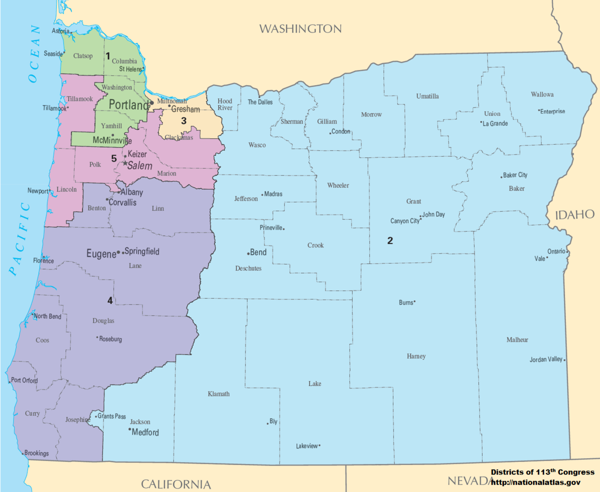

In [3]:
Image.open('Oregon_Congressional_Districts,_113th.png').resize((600, 492))

## Oregon is likely to gain a Congressional District from the 2020 Census
* The people of Oregon were already close to gaining their 6th Congressional District from the 2010 Census, according to the following infographic from the Pew Research Center.
* With the higher than average population growth rate, drawing the 6th District will have representative impact for the next decade and an incremental influence on presidential elections.

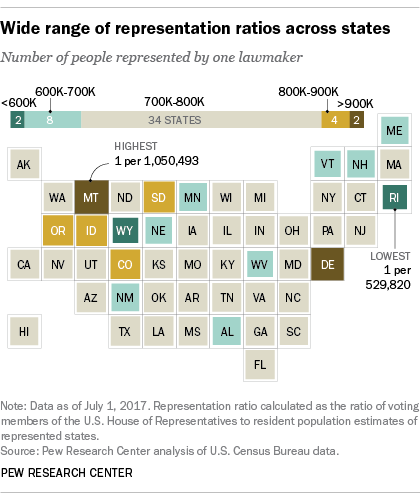

In [4]:
Image.open('FT_18.05.18_RepresentationRatios_states.png')

## Oregon's population varies greatly by its 36 counties

In [5]:
county_id = np.arange(0, 36)
county_names = np.array(['Baker','Benton','Clackamas','Clatsop','Columbia','Coos','Crook','Curry','Deschutes','Douglas','Gilliam','Grant','Harney','Hood River','Jackson','Jefferson','Josephine','Klamath','Lake','Lane','Lincoln','Linn','Malheur','Marion','Morrow','Multnomah','Polk','Sherman','Tillamook','Umatilla','Union','Wallowa','Wasco','Washington','Wheeler','Yamhill']) 
population_by_county = pd.DataFrame({'County_ID': county_id,
                                     'County_Name': county_names,
                                     #2020e from PSU: https://sos.oregon.gov/blue-book/Pages/local/county-population.aspx#InplviewHash04115801-432c-47bf-aef3-abafd774261d=SortField%3DCounty-SortDir%3DAsc
                                     'Population2020e' : [16910,94665,426515,39455,53280,63315,23440,23005,197015,112530,1990,7315,7280,25640,223240,24105,86560,68560,8075,381365,48305,127320,32105,349120,12825,829560,83805,1795,26530,81495,26840,7160,27295,620080,1440,108605],
                                     'Population2010' : [16134,85579,375992,37039,49351,63043,20978,22364,157733,107667,1871,7445,7422,22346,203206,21720,82713,66380,7895,351715,46034,116672,31313,315335,11173,735334,75403,1765,25250,75889,25748,7008,25213,529710,1441,99193],
                                     'Latitude': [44.7346,44.4929,45.3088,46.1068,45.9189,43.175,44.1533,42.6002,43.9856,43.253,45.4204,44.5335,43.2214,45.6007,42.4441,44.4914,42.3351,42.5663,42.7821,44.0123,44.6733,44.4924,43.9454,44.9367,45.4757,45.5437,44.9262,45.4041,45.3957,45.726,45.3181,45.5356,45.3856,45.5404,44.7845,45.2256],
                                     'Longitude': [-117.6777,-123.3844,-122.3999,-123.8773,-122.9863,-124.179,-120.4523,-124.3343,-121.1699,-123.373,-120.2077,-119.0668,-119.0481,-121.7147,-122.7875,-121.3246,-123.5119,-121.6302,-120.4691,-123.1668,-123.9267,-122.7806,-117.484,-122.7301,-119.6694,-122.5346,-123.3237,-120.7307,-123.8622,-118.745,-117.9619,-117.2036,-121.2283,-123.002,-120.02,-123.1982]})
population_by_county['Change2010_2020'] = population_by_county['Population2020e'] - population_by_county['Population2010']

df_county_names = pd.DataFrame(county_names, columns = ['County'])
df = pd.DataFrame()
df['County']  = county_names
df['CountySort'] = county_id

shapefile_oregon = gpd.read_file('orcounty.shp')
map_population_by_county_data = shapefile_oregon.merge(population_by_county, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
county_populations = np.array(population_by_county['Population2020e'])
state_population = sum(county_populations)
population_by_county.sort_values('Population2020e', ascending = False).head()

,County_ID,County_Name,Population2020e,Population2010,Latitude,Longitude,Change2010_2020
25,25,Multnomah,829560,735334,45.5437,-122.5346,94226
33,33,Washington,620080,529710,45.5404,-123.0020,90370
2,2,Clackamas,426515,375992,45.3088,-122.3999,50523
19,19,Lane,381365,351715,44.0123,-123.1668,29650
23,23,Marion,349120,315335,44.9367,-122.7301,33785


## The Willamette River valley contributes to ~70% of the state population

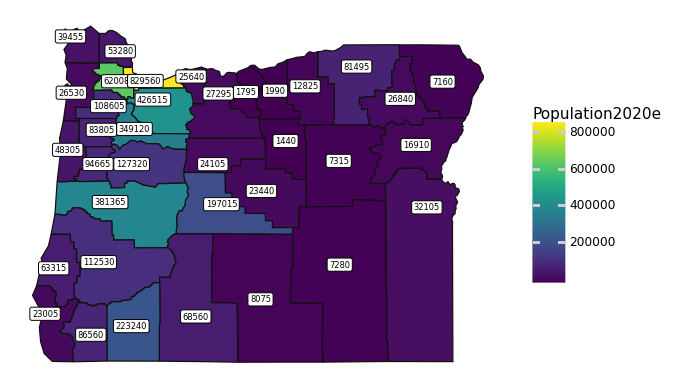

<ggplot: (8766911157724)>

In [6]:
map_population_by_county = (
ggplot(map_population_by_county_data)
+ geom_map(aes(fill='Population2020e'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Population2020e',size=2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank()
       )
)
map_population_by_county

## Population growth from 2010 to 2018 (estimated) occurred in the most populous counties.

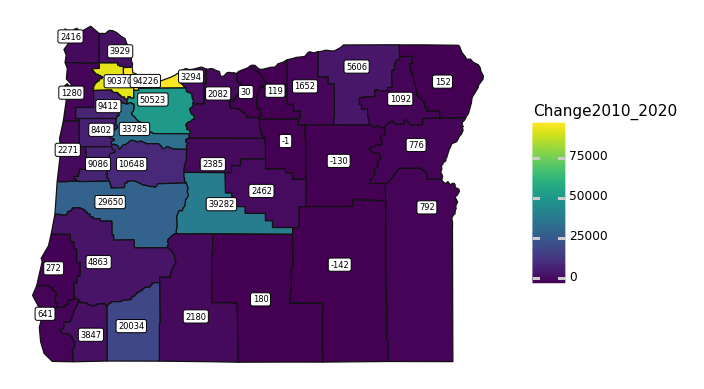

<ggplot: (8766911224308)>

In [7]:
map_population_change_by_county = (
ggplot(map_population_by_county_data)
+ geom_map(aes(fill='Change2010_2020'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Change2010_2020', size=2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank()
       )
)
map_population_change_by_county

# Optimization Model

The first step in this modeling process is to run the following optimization model.  After running the initial model, additional constraints will be added to hone in on the solution.  In practice, an algorithm can be written to create such additional constraints.  The next steps will show why such an algorithm is necessary.

In [8]:
n_counties = 36
n_districts = 6

model = LpProblem("Supply-Demand-Problem", LpMinimize) # create model
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) for i in range(1, n_counties+1)]
variable_names.sort() # print("Variable Indices:", variable_names)

# decision variables
# assignment is whether or not the county is assigned to the district
DV_variable_y = LpVariable.matrix("Y",variable_names,cat="Binary")
assignment = np.array(DV_variable_y).reshape(36,6)

# allocation is the amount of population from a county to a district
DV_variable_x = LpVariable.matrix("X",variable_names,cat="Integer",lowBound=0)#upBound N/A
allocation = np.array(DV_variable_x).reshape(36,6)    

In [9]:
# This objective function minimizes the counties are split among multiple districts.
objective_function = lpSum(assignment) 
model += objective_function

In [10]:
# Initial Assignment / Allocation Constraints

# allocate exactly 100% of population from each county 
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)

for i in range(n_counties): 
    for j in range(n_districts):
        # allocation can only be greater than zero if assignment is greater than zero
        # sum(county_populations) is a big M, which is the Oregon total population
        model += allocation[i][j] <= sum(county_populations)*assignment[i][j] , "Allocation assignment " + str(i) + str(j)
        if assignment[i][j] == 1:
            # at least 20% of population must be allocated to each district for that county
            model += allocation[i][j] >= assignment[i][j]*0.20*county_populations[i] , "Allocation min " + str(i) + str(j)

# Contiguous districts constraints
# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)
# Optionally, add `2*` to the left hand side so that the county is required to border at least two counties from the same district
for j in range(n_districts):
    model += assignment[0][j] <= assignment[11][j]+assignment[22][j]+assignment[30][j]+assignment[31][j]  
    model += assignment[1][j] <= assignment[19][j]+assignment[20][j]+assignment[21][j]+assignment[26][j] 
    model += assignment[2][j] <= assignment[13][j]+assignment[23][j]+assignment[25][j]+assignment[32][j]+assignment[33][j]+assignment[35][j]
    model += assignment[3][j] <= assignment[4][j]+assignment[28][j] 
    model += assignment[4][j] <= assignment[3][j]+assignment[25][j]+assignment[33][j]
    model += assignment[5][j] <= assignment[7][j]+assignment[9][j] 
    model += assignment[6][j] <= assignment[8][j]+assignment[11][j]+assignment[12][j]+assignment[15][j]+assignment[34][j]
    model += assignment[7][j] <= assignment[5][j]+assignment[9][j]+assignment[16][j] 
    model += assignment[8][j] <= assignment[6][j]+assignment[12][j]+assignment[15][j]+assignment[17][j]+assignment[18][j]+assignment[19][j]+assignment[21][j]
    model += assignment[9][j] <= assignment[5][j]+assignment[7][j]+assignment[14][j]+assignment[16][j]+assignment[17][j]+assignment[19][j]
    model += assignment[10][j] <= assignment[24][j]+assignment[27][j]+assignment[32][j]+assignment[34][j]
    model += assignment[11][j] <= assignment[0][j]+assignment[6][j]+assignment[12][j]+assignment[22][j]+assignment[24][j]+assignment[29][j]+assignment[30][j]+assignment[34][j]
    model += assignment[12][j] <= assignment[6][j]+assignment[8][j]+assignment[11][j]+assignment[18][j]+assignment[22][j]
    model += assignment[13][j] <= assignment[2][j]+assignment[25][j]+assignment[32][j]
    model += assignment[14][j] <= assignment[9][j]+assignment[16][j]+assignment[17][j]
    model += assignment[15][j] <= assignment[6][j]+assignment[8][j]+assignment[21][j]+assignment[23][j]+assignment[32][j]+assignment[34][j]
    model += assignment[16][j] <= assignment[7][j]+assignment[9][j]+assignment[14][j]
    model += assignment[17][j] <= assignment[8][j]+assignment[9][j]+assignment[14][j]+assignment[18][j]+assignment[19][j]
    model += assignment[18][j] <= assignment[8][j]+assignment[12][j]+assignment[17][j]
    model += assignment[19][j] <= assignment[1][j]+assignment[8][j]+assignment[9][j]+assignment[17][j]+assignment[20][j]+assignment[21][j]
    model += assignment[20][j] <= assignment[1][j]+assignment[19][j]+assignment[26][j]+assignment[28][j]
    model += assignment[21][j] <= assignment[1][j]+assignment[8][j]+assignment[15][j]+assignment[19][j]+assignment[23][j]+assignment[26][j] 
    model += assignment[22][j] <= assignment[0][j]+assignment[11][j]+assignment[12][j]
    model += assignment[23][j] <= assignment[2][j]+assignment[15][j]+assignment[21][j]+assignment[26][j]+assignment[32][j]+assignment[35][j]
    model += assignment[24][j] <= assignment[10][j]+assignment[11][j]+assignment[29][j]+assignment[34][j]
    model += assignment[25][j] <= assignment[2][j]+assignment[4][j]+assignment[13][j]+assignment[33][j]
    model += assignment[26][j] <= assignment[1][j]+assignment[20][j]+assignment[21][j]+assignment[23][j]+assignment[28][j]+assignment[35][j]
    model += assignment[27][j] <= assignment[10][j]+assignment[32][j]
    model += assignment[28][j] <= assignment[3][j]+assignment[20][j]+assignment[26][j]+assignment[33][j]+assignment[35][j]
    model += assignment[29][j] <= assignment[11][j]+assignment[24][j]+assignment[30][j]+assignment[31][j]
    model += assignment[30][j] <= assignment[0][j]+assignment[11][j]+assignment[29][j]+assignment[31][j]
    model += assignment[31][j] <= assignment[0][j]+assignment[29][j]+assignment[30][j]
    model += assignment[32][j] <= assignment[2][j]+assignment[10][j]+assignment[13][j]+assignment[15][j]+assignment[23][j]+assignment[27][j]+assignment[34][j]
    model += assignment[33][j] <= assignment[2][j]+assignment[4][j]+assignment[25][j]+assignment[28][j]+assignment[35][j]
    model += assignment[34][j] <= assignment[6][j]+assignment[10][j]+assignment[11][j]+assignment[15][j]+assignment[24][j]+assignment[32][j]
    model += assignment[35][j] <= assignment[2][j]+assignment[23][j]+assignment[26][j]+assignment[28][j]+assignment[33][j]
    
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= 750000 , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= 650000 , "District Size Minimum " + str(j)

# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > 220,000 to be split among up to two districts
for i in range(n_counties): # added
    if county_populations[i] <= 220000: 
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment " + str(i) 
    else:
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments " + str(i)

In [11]:
# # Improvement Assignment / Allocation Constraints (sometimes known as cuts)

# # pairs of counties that are far apart geographically with population centers in between them
# for j in range(n_districts):
#     # East counties not to be assigned to the west beyond population centers in the middle
#     # 0, 11, 12, 22, 24, 29, 30, 31
#     # Baker (0) on the east not to be assigned to the west beyond population centers in the middle
#     model += assignment[0][j] + assignment[1][j] <= 1 
#     model += assignment[0][j] + assignment[3][j] <= 1 
#     model += assignment[0][j] + assignment[4][j] <= 1 
#     model += assignment[0][j] + assignment[5][j] <= 1 
#     model += assignment[0][j] + assignment[6][j] <= 1 
#     model += assignment[0][j] + assignment[19][j] <= 1 
#     model += assignment[0][j] + assignment[20][j] <= 1 
#     model += assignment[0][j] + assignment[21][j] <= 1 
#     model += assignment[0][j] + assignment[23][j] <= 1 
#     model += assignment[0][j] + assignment[25][j] <= 1 
#     model += assignment[0][j] + assignment[26][j] <= 1 
#     model += assignment[0][j] + assignment[28][j] <= 1 
#     model += assignment[0][j] + assignment[33][j] <= 1 
#     model += assignment[0][j] + assignment[35][j] <= 1 
#     # same with Grant (11)
#     model += assignment[11][j] + assignment[1][j] <= 1 
#     model += assignment[11][j] + assignment[3][j] <= 1 
#     model += assignment[11][j] + assignment[4][j] <= 1 
#     model += assignment[11][j] + assignment[5][j] <= 1 
#     model += assignment[11][j] + assignment[6][j] <= 1 
#     model += assignment[11][j] + assignment[19][j] <= 1
#     model += assignment[11][j] + assignment[20][j] <= 1
#     model += assignment[11][j] + assignment[21][j] <= 1
#     model += assignment[11][j] + assignment[23][j] <= 1
#     model += assignment[11][j] + assignment[25][j] <= 1
#     model += assignment[11][j] + assignment[26][j] <= 1
#     model += assignment[11][j] + assignment[28][j] <= 1
#     model += assignment[11][j] + assignment[33][j] <= 1
#     model += assignment[11][j] + assignment[35][j] <= 1
#     # same with Harney (12)
#     model += assignment[12][j] + assignment[1][j] <= 1 
#     model += assignment[12][j] + assignment[3][j] <= 1 
#     model += assignment[12][j] + assignment[4][j] <= 1 
#     model += assignment[12][j] + assignment[5][j] <= 1 
#     model += assignment[12][j] + assignment[6][j] <= 1 
#     model += assignment[12][j] + assignment[19][j] <= 1
#     model += assignment[12][j] + assignment[20][j] <= 1
#     model += assignment[12][j] + assignment[21][j] <= 1
#     model += assignment[12][j] + assignment[23][j] <= 1
#     model += assignment[12][j] + assignment[25][j] <= 1
#     model += assignment[12][j] + assignment[26][j] <= 1
#     model += assignment[12][j] + assignment[28][j] <= 1
#     model += assignment[12][j] + assignment[33][j] <= 1
#     model += assignment[12][j] + assignment[35][j] <= 1
#     # same with Malheur (22)
#     model += assignment[22][j] + assignment[1][j] <= 1 
#     model += assignment[22][j] + assignment[3][j] <= 1 
#     model += assignment[22][j] + assignment[4][j] <= 1 
#     model += assignment[22][j] + assignment[5][j] <= 1 
#     model += assignment[22][j] + assignment[6][j] <= 1 
#     model += assignment[22][j] + assignment[19][j] <= 1
#     model += assignment[22][j] + assignment[20][j] <= 1
#     model += assignment[22][j] + assignment[21][j] <= 1
#     model += assignment[22][j] + assignment[23][j] <= 1
#     model += assignment[22][j] + assignment[25][j] <= 1
#     model += assignment[22][j] + assignment[26][j] <= 1
#     model += assignment[22][j] + assignment[28][j] <= 1
#     model += assignment[22][j] + assignment[33][j] <= 1
#     model += assignment[22][j] + assignment[35][j] <= 1
#     # same with Morrow (24)
#     model += assignment[24][j] + assignment[1][j] <= 1 
#     model += assignment[24][j] + assignment[3][j] <= 1 
#     model += assignment[24][j] + assignment[4][j] <= 1 
#     model += assignment[24][j] + assignment[5][j] <= 1 
#     model += assignment[24][j] + assignment[6][j] <= 1 
#     model += assignment[24][j] + assignment[19][j] <= 1
#     model += assignment[24][j] + assignment[20][j] <= 1
#     model += assignment[24][j] + assignment[21][j] <= 1
#     model += assignment[24][j] + assignment[23][j] <= 1
#     model += assignment[24][j] + assignment[25][j] <= 1
#     model += assignment[24][j] + assignment[26][j] <= 1
#     model += assignment[24][j] + assignment[28][j] <= 1
#     model += assignment[24][j] + assignment[33][j] <= 1
#     model += assignment[24][j] + assignment[35][j] <= 1
#     # same with Umatilla (29)
#     model += assignment[29][j] + assignment[1][j] <= 1 
#     model += assignment[29][j] + assignment[3][j] <= 1 
#     model += assignment[29][j] + assignment[4][j] <= 1 
#     model += assignment[29][j] + assignment[5][j] <= 1 
#     model += assignment[29][j] + assignment[6][j] <= 1 
#     model += assignment[29][j] + assignment[19][j] <= 1
#     model += assignment[29][j] + assignment[20][j] <= 1
#     model += assignment[29][j] + assignment[21][j] <= 1
#     model += assignment[29][j] + assignment[23][j] <= 1
#     model += assignment[29][j] + assignment[25][j] <= 1
#     model += assignment[29][j] + assignment[26][j] <= 1
#     model += assignment[29][j] + assignment[28][j] <= 1
#     model += assignment[29][j] + assignment[33][j] <= 1
#     model += assignment[29][j] + assignment[35][j] <= 1
#     # same with Union (30)
#     model += assignment[30][j] + assignment[1][j] <= 1 
#     model += assignment[30][j] + assignment[3][j] <= 1 
#     model += assignment[30][j] + assignment[4][j] <= 1 
#     model += assignment[30][j] + assignment[5][j] <= 1 
#     model += assignment[30][j] + assignment[6][j] <= 1 
#     model += assignment[30][j] + assignment[19][j] <= 1
#     model += assignment[30][j] + assignment[20][j] <= 1
#     model += assignment[30][j] + assignment[21][j] <= 1
#     model += assignment[30][j] + assignment[23][j] <= 1
#     model += assignment[30][j] + assignment[25][j] <= 1
#     model += assignment[30][j] + assignment[26][j] <= 1
#     model += assignment[30][j] + assignment[28][j] <= 1
#     model += assignment[30][j] + assignment[33][j] <= 1
#     model += assignment[30][j] + assignment[35][j] <= 1
#     # same with Wallowa (31)
#     model += assignment[31][j] + assignment[1][j] <= 1 
#     model += assignment[31][j] + assignment[3][j] <= 1 
#     model += assignment[31][j] + assignment[4][j] <= 1 
#     model += assignment[31][j] + assignment[5][j] <= 1 
#     model += assignment[31][j] + assignment[6][j] <= 1 
#     model += assignment[31][j] + assignment[19][j] <= 1 
#     model += assignment[31][j] + assignment[20][j] <= 1 
#     model += assignment[31][j] + assignment[21][j] <= 1 
#     model += assignment[31][j] + assignment[23][j] <= 1 
#     model += assignment[31][j] + assignment[25][j] <= 1 
#     model += assignment[31][j] + assignment[26][j] <= 1 
#     model += assignment[31][j] + assignment[28][j] <= 1 
#     model += assignment[31][j] + assignment[33][j] <= 1 
#     model += assignment[31][j] + assignment[35][j] <= 1 
#     # southwest counties (5,6,9,19) shouldn't be in the same district as north counties
#     # Coos County (5)
#     model += assignment[5][j] + assignment[3][j] <= 1
#     model += assignment[5][j] + assignment[4][j] <= 1
#     model += assignment[5][j] + assignment[6][j] <= 1
#     model += assignment[5][j] + assignment[10][j] <= 1
#     model += assignment[5][j] + assignment[11][j] <= 1
#     model += assignment[5][j] + assignment[13][j] <= 1
#     model += assignment[5][j] + assignment[15][j] <= 1
#     model += assignment[5][j] + assignment[24][j] <= 1
#     model += assignment[5][j] + assignment[27][j] <= 1
#     model += assignment[5][j] + assignment[28][j] <= 1
#     model += assignment[5][j] + assignment[32][j] <= 1
#     model += assignment[5][j] + assignment[34][j] <= 1
#     # Curry County (7)
#     model += assignment[7][j] + assignment[3][j] <= 1
#     model += assignment[7][j] + assignment[4][j] <= 1
#     model += assignment[7][j] + assignment[6][j] <= 1
#     model += assignment[7][j] + assignment[10][j] <= 1
#     model += assignment[7][j] + assignment[11][j] <= 1
#     model += assignment[7][j] + assignment[13][j] <= 1
#     model += assignment[7][j] + assignment[15][j] <= 1
#     model += assignment[7][j] + assignment[24][j] <= 1
#     model += assignment[7][j] + assignment[27][j] <= 1
#     model += assignment[7][j] + assignment[28][j] <= 1
#     model += assignment[7][j] + assignment[32][j] <= 1
#     model += assignment[7][j] + assignment[34][j] <= 1
#     # Douglas County (9)
#     model += assignment[9][j] + assignment[3][j] <= 1
#     model += assignment[9][j] + assignment[4][j] <= 1
#     model += assignment[9][j] + assignment[6][j] <= 1
#     model += assignment[6][j] + assignment[10][j] <= 1
#     model += assignment[9][j] + assignment[11][j] <= 1
#     model += assignment[9][j] + assignment[13][j] <= 1
#     model += assignment[9][j] + assignment[15][j] <= 1
#     model += assignment[9][j] + assignment[24][j] <= 1
#     model += assignment[9][j] + assignment[27][j] <= 1
#     model += assignment[9][j] + assignment[28][j] <= 1
#     model += assignment[9][j] + assignment[32][j] <= 1
#     model += assignment[9][j] + assignment[34][j] <= 1
#     # Lane County (19)
#     model += assignment[19][j] + assignment[3][j] <= 1
#     model += assignment[19][j] + assignment[4][j] <= 1
#     model += assignment[19][j] + assignment[6][j] <= 1
#     model += assignment[19][j] + assignment[10][j] <= 1
#     model += assignment[19][j] + assignment[11][j] <= 1
#     model += assignment[19][j] + assignment[13][j] <= 1
#     model += assignment[19][j] + assignment[15][j] <= 1
#     model += assignment[19][j] + assignment[24][j] <= 1
#     model += assignment[19][j] + assignment[27][j] <= 1
#     model += assignment[19][j] + assignment[28][j] <= 1
#     model += assignment[19][j] + assignment[32][j] <= 1
#     model += assignment[19][j] + assignment[34][j] <= 1
#     # northwest counties (3,4,28) shouldn't be in the same district as counties on other side of population centers
#     model += assignment[3][j] + assignment[1][j] <= 1
#     model += assignment[3][j] + assignment[6][j] <= 1
#     model += assignment[3][j] + assignment[8][j] <= 1
#     model += assignment[3][j] + assignment[10][j] <= 1
#     model += assignment[3][j] + assignment[21][j] <= 1
#     model += assignment[3][j] + assignment[27][j] <= 1
#     model += assignment[4][j] + assignment[1][j] <= 1
#     model += assignment[4][j] + assignment[6][j] <= 1
#     model += assignment[4][j] + assignment[8][j] <= 1
#     model += assignment[4][j] + assignment[10][j] <= 1
#     model += assignment[4][j] + assignment[21][j] <= 1
#     model += assignment[4][j] + assignment[27][j] <= 1
#     model += assignment[28][j] + assignment[1][j] <= 1
#     model += assignment[28][j] + assignment[6][j] <= 1
#     model += assignment[28][j] + assignment[8][j] <= 1
#     model += assignment[28][j] + assignment[10][j] <= 1
#     model += assignment[28][j] + assignment[21][j] <= 1
#     model += assignment[28][j] + assignment[27][j] <= 1
#     # multnomah (25)
#     model += assignment[5][j] + assignment[25][j] <= 1 
#     model += assignment[6][j] + assignment[25][j] <= 1 
#     model += assignment[7][j] + assignment[25][j] <= 1 
#     model += assignment[9][j] + assignment[25][j] <= 1 
#     model += assignment[10][j] + assignment[25][j] <= 1
#     model += assignment[16][j] + assignment[25][j] <= 1
#     model += assignment[17][j] + assignment[25][j] <= 1
#     model += assignment[18][j] + assignment[25][j] <= 1
#     model += assignment[19][j] + assignment[25][j] <= 1
#     model += assignment[20][j] + assignment[25][j] <= 1
#     model += assignment[21][j] + assignment[25][j] <= 1
#     model += assignment[23][j] + assignment[25][j] <= 1
#     model += assignment[26][j] + assignment[25][j] <= 1
#     model += assignment[27][j] + assignment[25][j] <= 1
#     model += assignment[28][j] + assignment[25][j] <= 1
#     model += assignment[34][j] + assignment[25][j] <= 1
#     # clackamas (2) 
#     model += assignment[2][j] + assignment[5][j] <= 1 
#     # these constraints from practice iterations
#     model += assignment[1][j] + assignment[6][j] <= 1
#     model += assignment[1][j] + assignment[34][j] <= 1
#     model += assignment[3][j] + assignment[32][j] <= 1 
#     model += assignment[3][j] + assignment[34][j] <= 1 
#     model += assignment[4][j] + assignment[22][j] <= 1 
#     model += assignment[4][j] + assignment[32][j] <= 1 
#     model += assignment[4][j] + assignment[34][j] <= 1 
#     model += assignment[7][j] + assignment[33][j] <= 1 
#     model += assignment[8][j] + assignment[26][j] <= 1 
#     model += assignment[8][j] + assignment[28][j] <= 1 
#     model += assignment[8][j] + assignment[33][j] <= 1 
#     model += assignment[9][j] + assignment[28][j] <= 1 
#     model += assignment[9][j] + assignment[33][j] <= 1 
#     model += assignment[10][j] + assignment[28][j] <= 1
#     model += assignment[14][j] + assignment[28][j] <= 1 
#     model += assignment[14][j] + assignment[33][j] <= 1 
#     model += assignment[16][j] + assignment[21][j] <= 1 
#     model += assignment[16][j] + assignment[33][j] <= 1 
#     model += assignment[17][j] + assignment[23][j] <= 1 
#     model += assignment[17][j] + assignment[26][j] <= 1 
#     model += assignment[17][j] + assignment[33][j] <= 1 
#     model += assignment[18][j] + assignment[23][j] <= 1 
#     model += assignment[18][j] + assignment[26][j] <= 1     
#     model += assignment[18][j] + assignment[28][j] <= 1 
#     model += assignment[18][j] + assignment[33][j] <= 1 
#     model += assignment[24][j] + assignment[28][j] <= 1 
#     model += assignment[28][j] + assignment[29][j] <= 1 

In [12]:
# solve the model
# default solver would be model.solve() or model.solve(PULP_CBC_CMD())
model.solve(GLPK_CMD(options=["--mipgap", "0.05", "--gomory"])) 
# !glpsol --help # details on solver parameters

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

The model status is:  Optimal
The objective value is:  38


Since there are 36 countiesthe lower bound for the objective function is 36.  
* An objective value of 38 would mean that there are two occasions that a county was assigned to two districts.

In [13]:
# data preparation for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'County': i,
            'District': j+1,
            'Assignment': int(assignment[i][j].value()*(j+1)),
            'Allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
assignment_results = pd.DataFrame(result_value)
assignment_results = assignment_results[assignment_results['Assignment'] != 0]
assignment_results = assignment_results.sort_values(['County','District'])
assignment_results = assignment_results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))
assignment_results['Multiple_County_Name'] = assignment_results['County_Name'].shift(periods=1)
assignment_results['Multiple_District'] = assignment_results['District'].shift(periods=1).fillna(99).astype(int)

# Editing the assignment variable to capture when a county is assigned to multiple districts
for i in range(0,len(assignment_results)):
    if assignment_results['County_Name'].loc[i] == assignment_results['Multiple_County_Name'].loc[i]:
        assignment_results.loc[i, 'Assignment'] =   int(str(assignment_results['District'].loc[i]) + \
                                                     str(assignment_results['Multiple_District'].loc[i]))
assignment_results = assignment_results.sort_values(['District','County_Name'])
assignment_results.index = assignment_results['County_ID']

In [14]:
color_dict = { 1 : 'khaki',
               2 : 'pink',
               3 : 'mediumaquamarine',
               4 : 'plum',
               5 : 'paleturquoise',
               6 : 'lightcoral',
               12: 'grey', 13: 'grey', 14: 'grey', 15: 'grey', 16: 'grey',
               21: 'grey', 23: 'grey', 24: 'grey', 25: 'grey', 26: 'grey',
               31: 'grey', 32: 'grey', 34: 'grey', 35: 'grey', 36: 'grey',
               41: 'grey', 42: 'grey', 43: 'grey', 45: 'grey', 46: 'grey',
               51: 'grey', 52: 'grey', 53: 'grey', 54: 'grey', 56: 'grey',
               61: 'grey', 62: 'grey', 63: 'grey', 64: 'grey', 65: 'grey'}
def oregon_map(map_data):
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x = 'Longitude', y = 'Latitude', label='Population2020e', size = 2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values = color_dict))
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x = 'Longitude', y = 'Latitude', label='County_Name_left', size = 2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values = color_dict))
    plot_map_county_ids = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x = 'Longitude', y = 'Latitude', label='County_ID', size = 5), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values = color_dict))
    return plot_map_population_labels, plot_map_county_labels, plot_map_county_ids


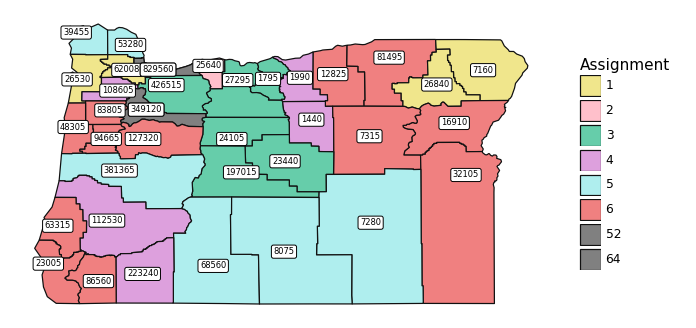

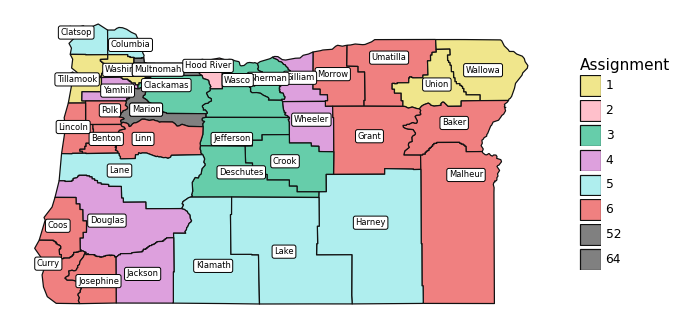

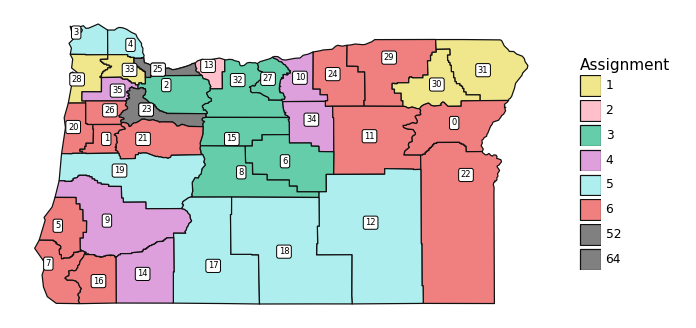

(<ggplot: (8766911366437)>,
 <ggplot: (8766911417131)>,
 <ggplot: (8766911159516)>)

In [15]:
map_first_pass = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
map_first_pass['District'] = map_first_pass['District']+1
map_first_pass_labels = map_first_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
map_first_pass_labels['District'] = map_first_pass_labels['District'].astype('category')
map_first_pass_labels['Assignment'] = map_first_pass_labels['Assignment'].astype("category")

oregon_map(map_first_pass_labels)

In [16]:
# Counties in Multiple Districts
assignment_results[['County_Name','District','Allocation']][assignment_results.duplicated(subset=['County_Name'],keep=False)].sort_values('County_Name')


,County_Name,District,Allocation
County_ID,,,
23,Marion,4,279296
23,Marion,6,69824
25,Multnomah,2,663648
25,Multnomah,5,165912


In [17]:
# Total Population by District
district_totals = pd.DataFrame(assignment_results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
district_totals

,Allocation
District,
1,"680,610"
2,"689,288"
3,"700,165"
4,"727,101"
5,"723,927"
6,"747,449"


In [19]:
# Verify that all population was assigned
print('State Population: ', f"{state_population:,.0f}")
print('Assigned Population: ', f"{value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):,.0f}", '\n')
if state_population == value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):
    print('All population was assigned to districts')
else:
    print('All population was not assigned to districts, investigate why this may have happened')

State Population:  4,268,540
Assigned Population:  4,268,540 

All population was assigned to districts


## Optional - Tweak the Solution
Switch two counties between districts. Then recalculate the solution and remap.

In [ ]:
# review solution 
# assignment_results

In [ ]:
# def change_districts(county_to_move, district_to_move_into):
#     """
#     Moves the chosen district into the chosen county.
#
#     Pass the County ID and the District number as parameters.
#     """
#     assignment_results.loc[county_to_move,'Assignment'] = district_to_move_into # for map
#     assignment_results.loc[county_to_move,'District'] = district_to_move_into # for sum by district
#     return print('The district has been updated')

In [ ]:
# change_districts(2,6) # moving from 

In [ ]:
# View the Tweaked Solution
# map_tweak = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
# map_tweak['District'] = map_tweak['District']+1
# map_tweak_labels = map_tweak.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
# map_tweak_labels['District'] = map_tweak_labels['District'].astype('category')
# map_tweak_labels['Assignment'] = map_tweak_labels['Assignment'].astype('category')
# oregon_map(map_tweak_labels)

In [ ]:
# # Total Population by District
# district_totals = pd.DataFrame(assignment_results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
# district_totals

In [30]:
# district_totals['Modified Allocation'] = district_totals['Allocation']
# district_totals.loc[1,'Modified Allocation'] = district_totals.loc[1,'Modified Allocation'] + population_by_county.loc[16,'Population2018'] - population_by_county.loc[17,'Population2018']
# district_totals.loc[5,'Modified Allocation'] = district_totals.loc[5,'Modified Allocation'] + population_by_county.loc[17,'Population2018'] - population_by_county.loc[16,'Population2018']

In [20]:
# district_totals['Change'] = district_totals['Modified Allocation'] - district_totals['Allocation']
# district_totals

In [21]:
# map_second_pass = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
# map_second_pass['District'] = map_second_pass['District']+1
# map_second_pass_labels = map_second_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
# map_second_pass_labels['District'] = map_second_pass_labels['District'].astype('category')
# map_second_pass_labels['Assignment'] = map_second_pass_labels['Assignment'].astype('category')
# oregon_map(map_second_pass_labels)